# Using Neural Networks for L96 Parameterization: Offline Training

## Outline:
In this notebook, we'll apply the concepts learned in the [previous notebook](https://m2lines.github.io/L96_demo/notebooks/gradient_decent.html) to the parameterization task in L96 model, which was highlighted [here](https://m2lines.github.io/L96_demo/notebooks/gcm-analogue.ipynb) and [here](https://m2lines.github.io/L96_demo/notebooks/gcm-parameterization-problem.ipynb). 

As a succinct reminder, the parameterization task requires us to represent the impact of the fast scales on the slow scales as a function of the slow scales. Machine learning provides us a way to learn complex non-linear functional dependecies from a given data set. In this notebook we will show :
- how the data to train a machine learning model is generated. 
- how a ML model can be trained to learn functional dependence in this data. 

## Generating the data

In [1]:
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [2]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

### Build the *Real World* to Generate the Ground Truth Dataset

Remeber from the [notebook](https://m2lines.github.io/L96_demo/notebooks/gcm-analogue.ipynb) that described the parameterization problem, the impact of the fast time scales on the slow time scales is captured by the term:

\begin{align}
\underbrace{ 
\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
}_{=U_k}.
\end{align}

The goal of the parameterization is to express $U_k$ purely as a function of the large scale variables $P(X_k)$. In the previous [notebook](https://m2lines.github.io/L96_demo/notebooks/gcm-analogue.ipynb) this was done using simple polynomial functions with specified form, but here we will estimate this function using a more general function - neural network.  

First we need to run a two time-scale model and generate data for $U_k$ and $X_k$.
We initialise the L96 two time-scale model using $K$ (set to 8) values of $X$ and $J$ (set to 32) values of $Y$ for each $X$. The model is run for 20,000 timesteps to generate the dataset for the neural network.

In [3]:
time_steps = 20000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=forcing)

### Run the simulation to generate data

Using the *real world* model created above we generate the training data (input and output pairs) for the neural network by running the simulation and writing out the large scale state and subgrid tendencies.

In [4]:
# The effect of Y on X is `xy_true`
X_true, _, _, xy_true = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true, xy_true = X_true.astype(np.float32), xy_true.astype(np.float32)

### Split the Data into Training and Testing Set

We split the data into 80% for training and 20% for testing. In more conventional ML tasks one may split the data into training, validation and testing sets, but for simplicity we do not do this here.

In [5]:
# Number of time steps for validation
val_size = 4000

# Training Data
X_true_train = X_true[
    :-val_size, :
]  # Flatten because we first use single input as a sample
subgrid_tend_train = xy_true[:-val_size, :]

# Test Data
X_true_test = X_true[-val_size:, :]
subgrid_tend_test = xy_true[-val_size:, :]

In [6]:
X_true_train.shape

(16001, 8)

## The Dataloaders 

In ML work flows it is common practice to create ways to access the data that allow for easily iterating over the whole data set. This is done because usually the datasets are very large, and breaking the data up into smaller chunks (batches) that can be loaded into memory (GPU or CPU) one at a time allow us to train using the whole dataset (see more details [here](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)). 

`Dataset` and `Dataloader` classes in PyTorch provide a very convenient way of iterating over a dataset while training a deep learning model.

In [7]:
# Number of sample in each batch
BATCH_SIZE = 2000
# this batch size would result in 2 test batches and 8 training batches.

Define the X (state), Y (subgrid tendency) pairs for the linear regression local network.

In [8]:
local_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_train, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)),
)

local_loader = Data.DataLoader(
    dataset=local_dataset, batch_size=BATCH_SIZE, shuffle=True
)

Define the dataloader for the test set.

In [9]:
local_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_test, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)),
)

local_loader_test = Data.DataLoader(
    dataset=local_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

Display a batch of samples from the dataset.

X (State):
 tensor([12.9715,  5.3797,  0.8659,  ...,  8.3222, -2.6947,  4.2560])

Y (Subgrid Tendency):
 tensor([-7.5589, -6.6147, -0.8452,  ..., -7.2965,  4.5814, -7.6241])


(-12.0, 16.0)

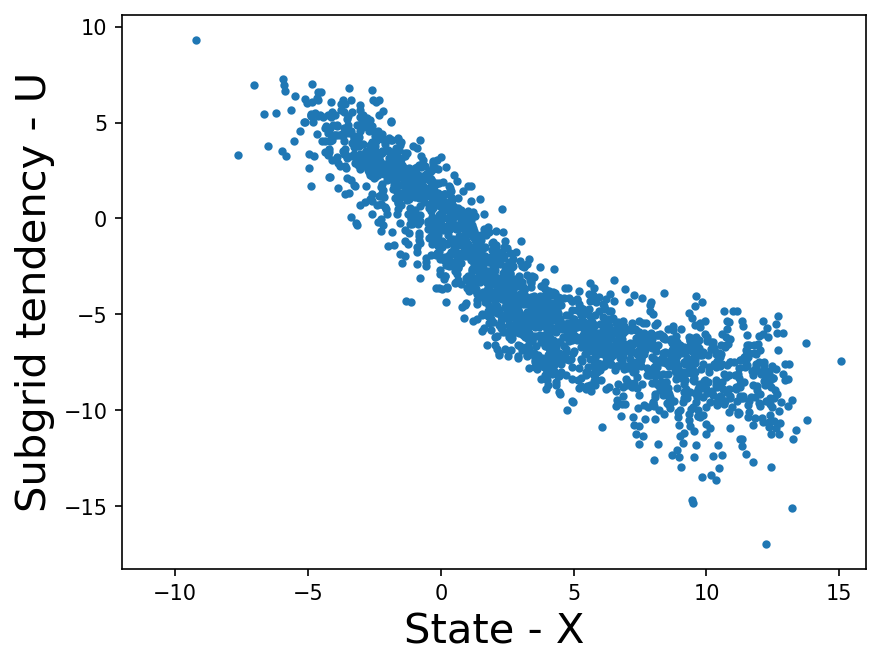

In [10]:
# Iterating over the data to get one batch
data_iterator = iter(local_loader)
X_iter, subgrid_tend_iter = next(data_iterator)

print("X (State):\n", X_iter)
print("\nY (Subgrid Tendency):\n", subgrid_tend_iter)

plt.figure(dpi=150)
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - U", fontsize=20)
plt.xlim([-12, 16])

Clearly there is a relationship between $U_k$ and $X_k$, we plan to learn this with the help of ML models.

## The *local* ML models

Here we show how a few different machine learning models can be setup. These models will predict the $U_k$ at a specific $k$ using the $X_k$ as the same $k$, and so may be considered local. Later we will consider non-local models, which predict $U_k$ at specific $k$ using $X_k$ at multiple locations (values of $k$). 

We will consider a linear regression network and a non-linear fully connected neural network (FCNN) here. 

### Linear regression network

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

In [ ]:
linear_network = LinearRegression()
linear_network

### Fully connected neural network (FCNN)

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 1)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
fcnn_network = FCNN()
fcnn_network

We do not expect the linear regression to do well in this problem, as the dependence seenin the figure is clearly more complex than a simple line. We include it here as a baseline. 

For the FCNN the non-linearity is introduced by adding the activation function, which is chosen to be ReLU in this case. The number of layers and width of layers are hyperparameters, which the practitioner needs to set based on some trial and error (or systematic hyperparameter sweeps). The goal is to make the network as complex as needed but no more.

```{admonition} Need for Activation Functions

**If layers of a neural network contain only fully-connected layers (matrix multiplications), everything would be linear.**

For example, if we have an input $x$ along with 2 layers of weight matrices $A$ and $B$ then the neural network would compute the output as $A(Bx)$, which is linear (in $x$). Thus, in order to introduce some non-linearity we use activation functions.

Now the same neural network as above with an activation function $\phi$ would compute the output as $A(\phi(Bx))$.
```

`````{admonition} ReLU Activation Function

```{figure} figs/relu_activation_function.png
:name: relu-activation
```

The `ReLU` activation function is just a $max(0,X)$ function (The image is referenced from [this blog](https://analyticsindiamag.com/most-common-activation-functions-in-neural-networks-and-rationale-behind-it/)). Even a function as simple as this enables a typical NN to be a nonlinear function of the inputs!
`````

**Test forward function**  
Below we test to see if the models can return an output given an input. Since at this point the models have not been trained (parameters have not been optimized) the resulting output is just a random number. 

In [ ]:
net_input = torch.randn(1, 1)
out_linear = linear_network(net_input)
out_fcnn = fcnn_network(net_input)
print(
    f"The output of the random input from the linear network is: {out_linear.item():.4f}"
)
print(f"The output of the random input from the fcnn is: {out_fcnn.item():.4f}")

## The Loss Function

Apart from the architecutre of the model, the other major component of any machine learning task is the loss function. This is basically some quantitative way to test the skill of the model - whether the model does a good job or not at estimating the output. During the optimization of the weights, the weights are changed such that the model skill is improved.

For our task, we choose the *Mean Squared Error* metric as our loss function. However, other loss functions may be used or need to be adapted to the problem. 

In [ ]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [ ]:
# Load the input and output pair from the data loader
X_tmp = next(iter(local_loader))

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1))
y_tmp_fcnn = fcnn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_fcnn = loss_fn(y_tmp_fcnn, torch.unsqueeze(X_tmp[1], 1))
print(f"FCNN MSE Loss: {loss_fcnn.item():.4f}")

Since at this point neither of the networks have been trained, the resultant loss is just arbitrary. If one model is doing better than the other, it is just a result of random chance. 

## The Optimizer

Now in order to make the network learn (optimize the parameters), we need an algorithm that will update its weights depending on the loss function. This is achieved by using an optimizer. The implementation of many optimizers can be found in PyTorch. The choice of which optimizer we choose might be very important as it will determine how fast the network will be able to learn.

In the example below, we show one of the popular optimizers `Adam`. The main hyperparameter in this optimizer is the **learning rate**. 


Another popular optimizer that may be useful in some situations is Stochastic Gradient Descent or `SGD`. 
The SGD optimizer consists of two major hyperparameters called the **learning rate** and **momentum**. The **learning rate** determines the magnitude with which the weights of the network update thus making it crucial to choose the correct learning rate ($LR$) otherwise the network will either fail to train, or take much longer to converge. **Momentum** determines how much of the loss function gradients are determined based on the past iteration vs the latest iteration. 
To read about momentum, check out this [blog post](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d).

The primary task of the optimizer is to update the parameters in little steps such that the loss function is reduced. In equations, the  effective value of the gradient $V$ (direction in which loss function reduces) at step $t$ in SGD with momentum ($\beta$) is determined by

\begin{equation}
V_t = \beta V_{t-1} + (1-\beta) \nabla_w L(W,X,y)
\end{equation}

and the updates to the parameters will be

\begin{equation}
w^{new} = w^{old} - LR * V_t
\end{equation}

See in the code sample below how taking a step with the optimizer changes the model parameters. In what comes next we will take these steps to reach a parameter state such that the loss function is as small as possible. 

In [ ]:
learning_rate = 0.003
momentum = 0.1

In [ ]:
# switch the commenting out below to try a different optimizer.
# optimizer_linear = optim.SGD(linear_network.parameters(), lr=learning_rate, momentum=momentum)
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate)
print("Before backward pass: \n", list(linear_network.parameters())[0].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

In [ ]:
# optimizer_fcnn = optim.SGD(fcnn_network.parameters(), lr=learning_rate, momentum=momentum)
optimizer_fcnn = optim.Adam(fcnn_network.parameters(), lr=learning_rate)

## Combining it all Together: Training the network

### Define the Training and Test Functions

The `train_model` function update the network weight such that the loss is reduced. A single call to this function iterates over all the batches in the dataset, and this single iteration is called an epoch. To do its job this function needs access to the model that needs to be trained, the criterion or the loss function that determines the skill of the model, the data loader that allows the model to access the data, and the optimizer that appropriately adjusts the weights to reduce the loss. Also notice that the model weights are adjusted multiple times in a single epoch - everytime a batch is processed. 

In [ ]:
def train_model(network, criterion, loader, optimizer):
    """Train the network for one epoch"""
    network.train()

    train_loss = 0
    for batch_x, batch_y in loader:
        # Get predictions
        if len(batch_x.shape) == 1:
            # This if block is needed to add a dummy dimension if our inputs are 1D
            # (where each number is a different sample)
            prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
        else:
            prediction = network(batch_x)

        # Compute the loss
        loss = criterion(prediction, batch_y)
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)

The `test_model` function is meant to test the skill of the model, but does not update the weights to further improve it. 

In [ ]:
def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers)

    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            # Get predictions
            if len(batch_x.shape) == 1:
                # This if block is needed to add a dummy dimension if our inputs are 1D
                # (where each number is a different sample)
                prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
            else:
                prediction = network(batch_x)

            # Compute the loss
            loss = criterion(prediction, batch_y)
            test_loss += loss.item()

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss

The `fit_model` iterates the `train_model` function over multiple epochs, such that the loss is reduced. 

In [ ]:
def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end_time = time.time()
    print(f"Training completed in {int(end_time - start_time)} seconds.")

    return train_losses, test_losses

### Train the networks

Finally we have all the components ready and we can train our models. 


In [ ]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 15

In [ ]:
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, local_loader, local_loader_test, n_epochs
)

In [ ]:
train_loss_fcnn, test_loss_fcnn = fit_model(
    fcnn_network, loss_fn, optimizer_fcnn, local_loader, local_loader_test, n_epochs
)

In [ ]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_fcnn, label="FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="FCNN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

### Compare Predictions with Ground Truth

In [ ]:
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)
predictions_fcnn = fcnn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)


plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Predicted from linear model"
)
plt.plot(predictions_fcnn.detach().numpy()[0:1000], label="Predicted from FCNN model")
plt.plot(subgrid_tend_test[:1000, 1], label="True Values", color="k", linestyle="--")
plt.legend(fontsize=7);

In [ ]:
X_points = torch.from_numpy(np.linspace(-10, 15, 31).astype(np.float32))

linear_pred = linear_network(torch.unsqueeze(X_points, 1)).detach().numpy()

fcnn_pred = fcnn_network(torch.unsqueeze(X_points, 1)).detach().numpy()


plt.figure(dpi=150)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")

plt.plot(X_points, linear_pred, "-", label="Linear predictions")
plt.plot(X_points, fcnn_pred, "-", label="FCNN predictions", color="g")

plt.legend()
plt.xlim([-12, 16])
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - U", fontsize=20);

As seen above, the FCNN does a better job at learning the relationship between the $X_k$ and $U_k$, when compared to the linear model.
Can we do even better? 

## The *non-local* ML models

It is possible that sub-grid tendency at $k$ depends on the neighbouring points (as shown in figure below), or points farther away. 

In [ ]:
plt.figure(figsize=(12, 4), dpi=150)

plt.subplot(131)
plt.hist2d(
    np.reshape(np.roll(X_true, -1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k-1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.subplot(132)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.subplot(133)
plt.hist2d(
    np.reshape(np.roll(X_true, 1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k+1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.tight_layout()

So to make more accurate model, one may want to build a model that learns relationship between not only the specific k point but also other k points. 

We will do this with the help of a non-local model, which uses all $X_k$s to predict the $U_k$ at all 8 $k$s.

To build this model, we need to change two things: 
- The data sets need to be slightly altered, such that each sample for the ML model will be composed of all eight k points. 
- The architecture of the neural network will have to be altered to take 8 inputs and produce 8 outputs.  

but apart from these changes, the rest of the training process is the same. 

In [ ]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train),
    torch.from_numpy(subgrid_tend_train),
)
nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=True
)


# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test), torch.from_numpy(subgrid_tend_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=True
)

In [ ]:
class NonLocal_FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
nonlocal_fcnn_network = NonLocal_FCNN()

In [ ]:
# optimizer_nonlocal_fcnn = optim.SGD(nonlocal_fcnn_network.parameters(),
#                                    lr=learning_rate, momentum=momentum)
optimizer_nonlocal_fcnn = optim.Adam(
    nonlocal_fcnn_network.parameters(), lr=learning_rate
)

In [ ]:
n_epochs = 120
train_loss_nonlocal, test_loss_nonlocal = fit_model(
    nonlocal_fcnn_network,
    loss_fn,
    optimizer_nonlocal_fcnn,
    nlocal_loader_train,
    nlocal_loader_test,
    n_epochs,
)

In [ ]:
plt.figure(dpi=150)

plt.plot(train_loss_nonlocal, label="Non-local model train loss")
plt.plot(test_loss_nonlocal, linestyle="--", label="Non-local model test loss")

plt.plot(train_loss_fcnn, label="local FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="local FCNN test loss")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.grid()
plt.show();

In [ ]:
k_loc = 1
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, k_loc], -1)), 1)
)
predictions_fcnn = fcnn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, k_loc], -1)), 1)
)

predictions_nonlocal_fcnn = nonlocal_fcnn_network(torch.from_numpy(X_true_test))


plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Predicted from linear model"
)
plt.plot(
    predictions_fcnn.detach().numpy()[0:1000], label="Predicted from local FCNN model"
)
plt.plot(
    predictions_nonlocal_fcnn.detach().numpy()[0:1000, k_loc],
    label="Predicted from non-local FCNN model",
)
plt.plot(subgrid_tend_test[:1000, 1], label="True Values", color="k", linestyle="--")
plt.legend(fontsize=7);

As seen above, the non-local model does about as good as the local model. It may be possible to improve the skill of the model by adjusting the hyperparameters associated with the training or model architecture, but we did not pursue this much more in this notebook. 

## Save the networks

Now we save the weights that were learnt here, so we can use them directly later without having to retrain the neural network. 

In [ ]:
# Save network
save_path = "./networks/non_local_FCNN.pth"
torch.save(nonlocal_fcnn_network.state_dict(), save_path)

save_path = "./networks/local_FCNN.pth"
torch.save(fcnn_network.state_dict(), save_path)

save_path = "./networks/linear.pth"
torch.save(linear_network.state_dict(), save_path)

## Summary

In this notebook we showed how machine learning based models, particularly fully connected neural networks, can be trained to learn the relationship between the sub-grid fluxes and the slow variables. This pattern learning exercise is sometimes referred to as offline training, as the skill of the ML model in an actual simulation of the slow variables (gcm) has not been evaluated. In the next notebook we show how these models trained offline can be incorporated into the gcm version of the L96 model, and how its skill can be evaluated.